 # **Predicting the Presence of Heart Disease Using Clinical Parameters**
 #### Mehardeep Singh,

In [5]:
# importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# **Introduction:**

Heart disease is a leading cause of death worldwide. Early detection of heart disease can lead to better management and improved patient outcomes. In this project, we aim to predict the presence of heart disease using several clinical parameters available in the Cleveland Heart Disease dataset from the UCI Machine Learning Repository.

The dataset contains several clinical parameters along with a target variable indicating the presence of heart disease. The parameters we'll be focusing on for our analysis are: age, type of chest pain, serum cholesterol levels, and maximum heart rate achieved.

# **Preliminary exploratory data analysis:**


In [17]:

# Seed for reproducibility
set.seed(123)

# Define column names and types
col_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "max_heart_rate", "exang", "oldpeak", "slope", "ca", "thal", "num")
col_types <- list("d", "d", "d", "d", "d", "d", "d", "d", "d", "d", "d", "f", "f", "d")

# Load the data
heart_data_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_data <- read_csv(heart_data_url, col_names = col_names, col_types = col_types)

# Replace "?" with NA
heart_data[heart_data == "?"] <- NA

# Clean and wrangle the data
clean_heart_data <- heart_data %>%
  mutate(heart_disease = ifelse(is.na(num), NA, (num > 0))) %>%
  mutate(sex = as.factor(as.integer(sex)), 
         cp = as.factor(as.integer(cp)), 
         fbs = as.factor(as.integer(fbs)), 
         restecg = as.factor(as.integer(restecg)),
         exang = as.factor(as.integer(exang)), 
         thal = as.factor(as.integer(thal)),
         ca = as.factor(as.integer(ca)), 
         slope = as.factor(as.integer(slope)))

# Split the data into training and testing sets
data_split <- initial_split(clean_heart_data, prop = 0.75, strata = num)

train_data <- training(data_split)
test_data <- testing(data_split)

# Display the first few rows of the training data
head(train_data)


age,sex,cp,trestbps,chol,fbs,restecg,max_heart_rate,exang,oldpeak,slope,ca,thal,num,heart_disease
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<lgl>
63,1,1,145,233,1,2,150,0,2.3,3,1,1,0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,1,2,0,FALSE
57,0,4,120,354,0,0,163,1,0.6,1,1,2,0,FALSE
57,1,4,140,192,0,0,148,0,0.4,2,1,1,0,FALSE
56,0,2,140,294,0,2,153,0,1.3,2,1,2,0,FALSE
44,1,2,120,263,0,0,173,0,0.0,1,1,3,0,FALSE


In [14]:

# Summarizing to get different summary statistics of each predictor + total no. of rows per class
heart_summary <- train_data %>%
  group_by(heart_disease) %>%
  summarize(
    count = n(),
    avg_age = mean(age, na.rm = TRUE),
    median_age = median(age, na.rm = TRUE),
    min_age = min(age, na.rm = TRUE),
    max_age = max(age, na.rm = TRUE),
    avg_cp = mean(as.numeric(as.character(cp)), na.rm = TRUE),
    median_cp = median(as.numeric(as.character(cp)), na.rm = TRUE),
    avg_trestbps = mean(trestbps, na.rm = TRUE),
    median_trestbps = median(trestbps, na.rm = TRUE),
    avg_chol = mean(chol, na.rm = TRUE),
    median_chol = median(chol, na.rm = TRUE),
    missing_data = sum(is.na(age) | is.na(cp) | is.na(trestbps) | is.na(chol))
  )

heart_summary


heart_disease,count,avg_age,median_age,min_age,max_age,avg_cp,median_cp,avg_trestbps,median_trestbps,avg_chol,median_chol,missing_data
<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,122,52.60656,52,29,76,2.827869,3,128.9836,130,244.6967,237.5,0
TRUE,103,56.94175,58,38,70,3.553398,4,135.4757,132,249.0777,247.0,0


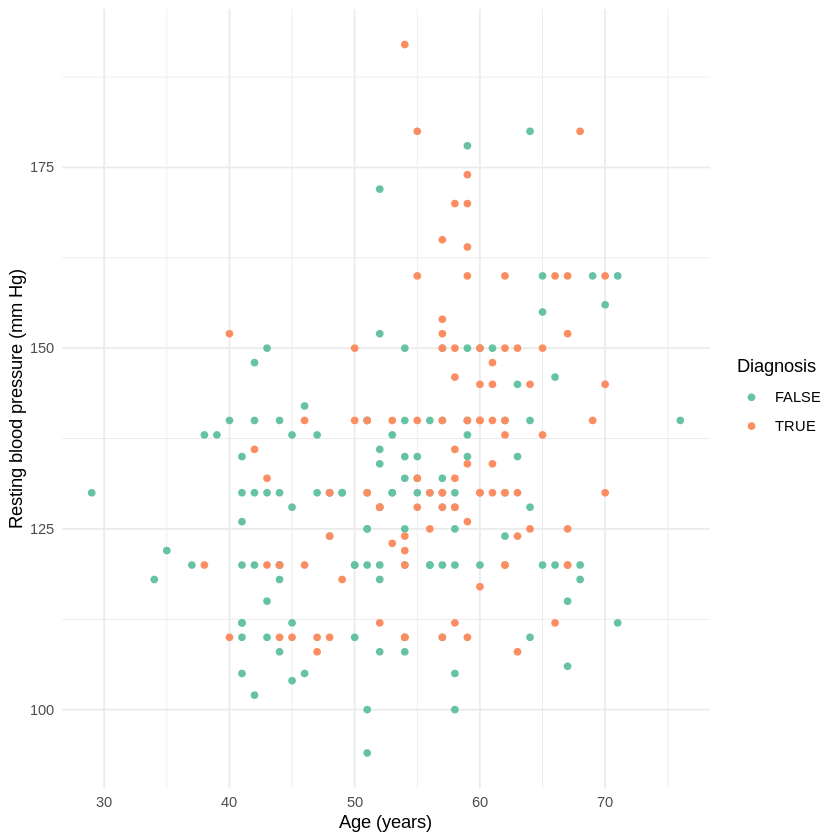

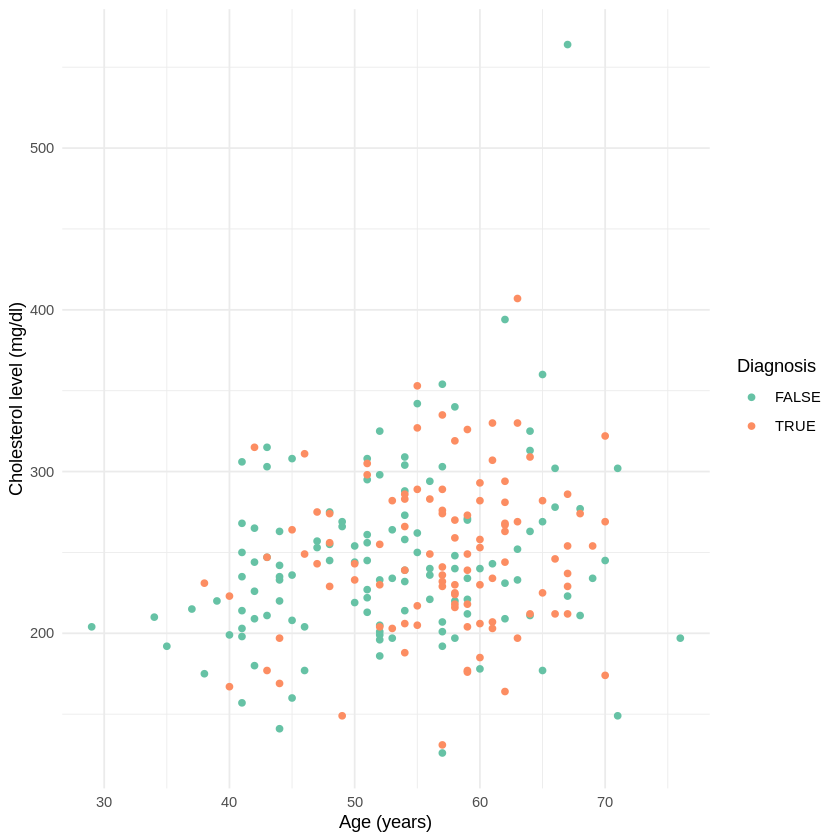

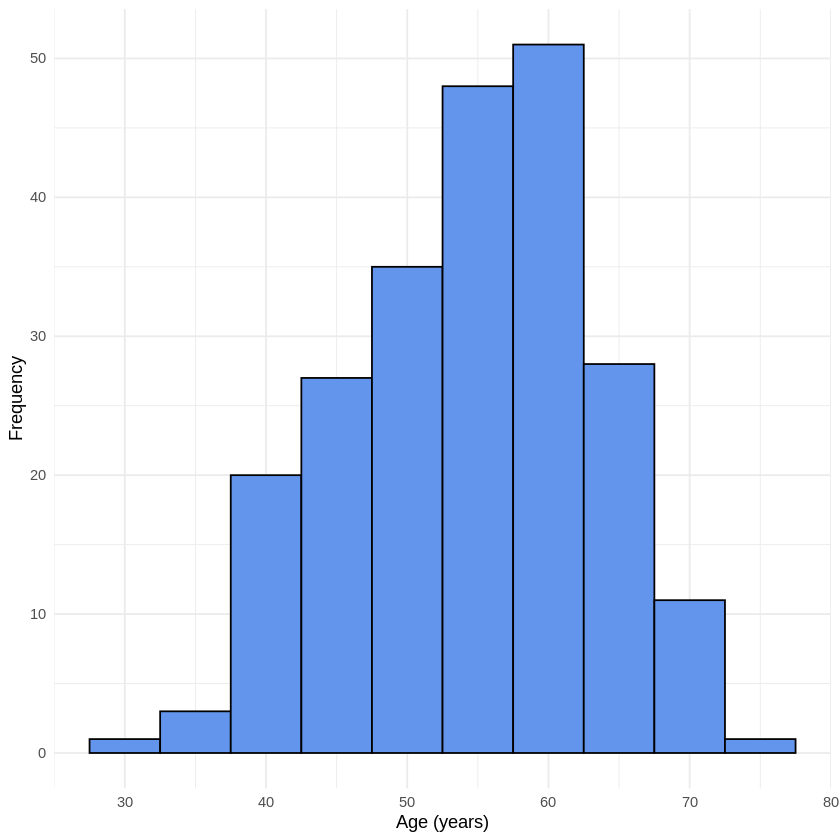

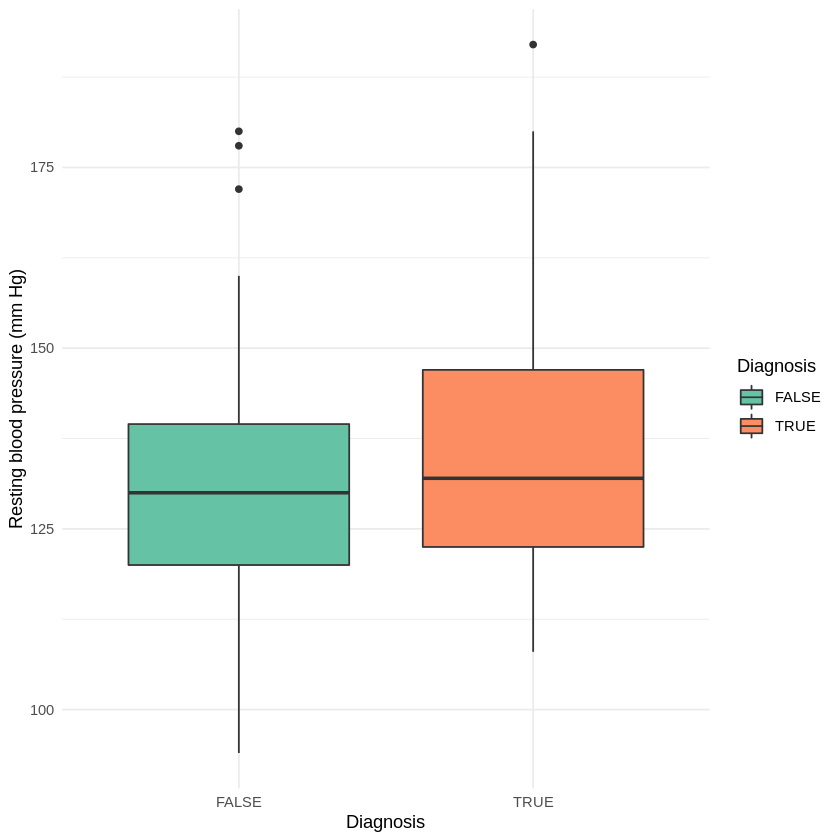

In [13]:
# Visualizing the Data
# Scatter plot 1 - Comparing age and trestbps
plot1 <- ggplot(train_data, aes(x = age, y = trestbps, color = heart_disease)) +
  geom_point() +
  labs(x = "Age (years)", y = "Resting blood pressure (mm Hg)", color = "Diagnosis") +
  theme_minimal() +
  scale_color_brewer(palette = "Set2")

# Scatter plot 2 - Comparing age and chol
plot2 <- ggplot(train_data, aes(x = age, y = chol, color = heart_disease)) +
  geom_point() +
  labs(x = "Age (years)", y = "Cholesterol level (mg/dl)", color = "Diagnosis") +
  theme_minimal() +
  scale_color_brewer(palette = "Set2")

# Histogram - Age distribution
plot3 <- ggplot(train_data, aes(x = age)) +
  geom_histogram(binwidth = 5, fill = "cornflowerblue", color = "black") +
  labs(x = "Age (years)", y = "Frequency") +
  theme_minimal()

# Boxplot - Distribution of resting blood pressure across diagnoses
plot4 <- ggplot(train_data, aes(x = heart_disease, y = trestbps, fill = heart_disease)) +
  geom_boxplot() +
  labs(x = "Diagnosis", y = "Resting blood pressure (mm Hg)", fill = "Diagnosis") +
  theme_minimal() +
  scale_fill_brewer(palette = "Set2")

plot1
plot2
plot3
plot4


# **Methods:**

We are using the Heart Disease Dataset obtained from the UCI Machine Learning Repository, specifically the processed.cleveland.data, to predict the presence of heart disease in individuals based on selected clinical parameters. The dataset contains the following variables:

1. **age**: Age of the patient
2. **cp**: Chest pain type
3. **trestbps**: Resting blood pressure (in mm Hg on admission to the hospital)
4. **chol**: Serum cholesterol in mg/dl
5. **thalach**: Maximum heart rate achieved

In addition to these, there are several other variables in the dataset such as sex, fasting blood sugar level, resting electrocardiographic results, exercise-induced angina, etc. However, for the scope of this project, we have chosen to focus on the four variables listed above as our predictors. We believe these variables provide key insight into an individual's cardiovascular health and are significant in predicting heart disease.

During the data cleaning process, we have addressed missing values represented as "?" in the original data, converting them into NA values to maintain the integrity of our analyses. Our target variable is the presence or absence of heart disease, originally presented in the num column of the dataset as an integer (values from 0 to 4). We have simplified this into a binary outcome - absence (0) or presence (1,2,3,4) of heart disease - and stored in a new column heart_disease.

We used the initial_split() function from the rsample package to divide our dataset into a training set (75% of the data) and a testing set (25% of the data), stratifying on the heart_disease column to ensure a similar distribution of cases in both sets. All exploratory data analysis and model training is conducted on the training dataset to prevent data leakage and overfitting.

Our exploratory data analysis includes summary statistics for each of our chosen predictors, divided by the target variable heart_disease. This analysis revealed insights such as a higher mean age and cholesterol level in individuals with heart disease compared to those without, and a lower mean maximum heart rate achieved.

We visualized our data using scatterplots, plotting each predictor against the other while coloring the points based on the heart_disease column. This allowed us to observe patterns and potential relationships between the variables, as well as between the predictors and the target outcome. These visualizations have further guided our choice of predictors for the logistic regression model.

In summary, based on our exploratory data analysis and literature on heart disease risk factors, we have selected age, cp, trestbps, and chol as our predictors for the logistic regression model. Our model will predict the binary outcome of heart disease presence or absence.

# **Expected Outcomes and Significance:**

We anticipate that our logistic regression model will accurately predict the presence or absence of heart disease in individuals based on the selected clinical parameters: age, chest pain type, resting blood pressure, and serum cholesterol level. We expect the model to reveal that patients with heart disease tend to be older, have specific types of chest pain, higher cholesterol levels, and possibly elevated blood pressure.

If our hypothesis is correct and our model proves effective, it could significantly enhance the preliminary screening process for heart disease. Physicians and healthcare providers could use this model as a tool to identify individuals who are potentially at risk of heart disease. Early identification of high-risk individuals means earlier intervention, which could result in better management and outcomes for patients.

Moreover, successful findings from our study could also pave the way for more extensive research in the field of predictive medicine. These might include the investigation of more complex models, incorporation of additional clinical parameters or lifestyle factors, and potential interactions between predictors.

Possible future questions that could be explored include:

What are the weightages of the selected predictors in the model, i.e., 
1. Which factors contribute the most to the risk of heart disease?
2. Could the inclusion of lifestyle factors such as diet, exercise, or smoking habits improve the predictive accuracy of the model?
3. How do the predictors interact, and do these interactions increase the risk of heart disease?
4. How can the insights gained from the predictive model be utilized in preventative healthcare measures to reduce the incidence of heart disease?
5. Thus, our study's findings could have a wide-ranging impact on both the practical and research aspects of cardiovascular health.